In [1]:
# Import all packages
import numpy as np
import pandas as pd
import tclab
import os
import imageio

# Import project-specific code
from project import PID, LSTMController as LSTM, PhysicsModel, utils

2023-12-13 15:47:35.421153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# TCLab Dynamics

In [2]:
# Initialize the model with some initial guess values
U = 10 # W/m2/K
epsilon = 0.9
A = 1.2e-3 # m2
mcp = 0.004 * 500 # J/K
model = PhysicsModel(U, epsilon, A, mcp)

In [3]:
# Get TCLab data by measuring it or loading previous data
minutes = 10
n = minutes * 60
tm = np.zeros(n + 1)
Q = np.zeros(n + 1)
Q[10:] = 80
Q[200:] = 20
Q[400:] = 60

T1_meas = np.zeros(n + 1)
i = 0

if not "dynamics_data.csv" in os.listdir("data"):

    TCLab = tclab.TCLab

    # Uncomment the following line to use the TCLab model instead
    #TCLab = tclab.setup(connected=False, speedup=20)

    with TCLab() as lab:
        for t in tclab.clock(n):
            tm[i] = t
            lab.Q1(Q[i])
            T1_meas[i] = lab.T1
            i += 1

    data = np.vstack((tm, Q, T1_meas)).T
    np.savetxt("data/dynamics_data.csv", data, delimiter=",", header="Time (s), Heater (%), T1 (°C)")

else:
    data = np.loadtxt("data/dynamics_data.csv", skiprows=1, delimiter=",").T
    tm = data[0]
    Q = data[1]
    T1_meas = data[2]

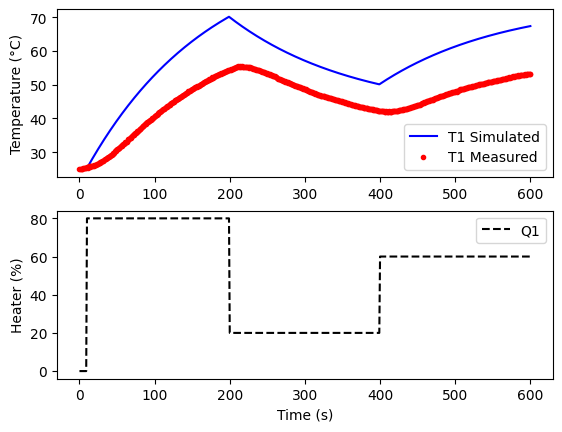

In [4]:
# Compare the initial guess to the measured data
model.plot_with_data(tm, Q, T1_meas)


Initial objective = 78216.99460181296
Final objective = 2088.278101955908

Regressed parameters:
U = 6.778808593202154 W/m2/K
epsilon = 0.4036469957039447
A = 0.0025408156233136655 m2
mcp = 3.4583726468316893 J/K


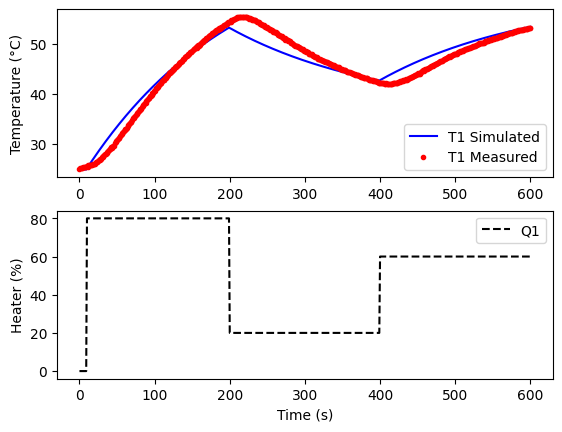

In [5]:
# Optimize the Physics-based model using the measured data
model.fit(tm, Q, T1_meas)

print("\nRegressed parameters:")
print(f"U = {model.U} W/m2/K")
print(f"epsilon = {model.epsilon}")
print(f"A = {model.A} m2")
print(f"mcp = {model.mcp} J/K")

# Compare the fitted model to the measure data
model.plot_with_data(tm, Q, T1_meas)

# LSTM Training

In [6]:
# Set this to True to generate new training data and replace previously generated data
generate_data = False

# Create a PID controller to generate training data
pid = PID(0, 10, 60, 0)
pid.set_bounds(0, 100)

# Generate the training data, plot it, and save it
if generate_data or not "lstm_training_data.csv" in os.listdir("data"):
    data = utils.generate_tclab_data(pid)
    utils.plot_tclab_data(data, to_file="plots/train_data.png")
    data.to_csv("data/lstm_training_data.csv", index=False)
else:
    data = pd.read_csv("data/lstm_training_data.csv")

data.head()

,Time,Q1,T1,SP1
0,0.00,0.0,20.9495,20.9495
1,1.07,0.0,20.9495,20.9495
2,2.26,0.0,20.9495,20.9495
3,3.06,0.0,20.9495,20.9495
4,4.12,0.0,20.9495,20.9495


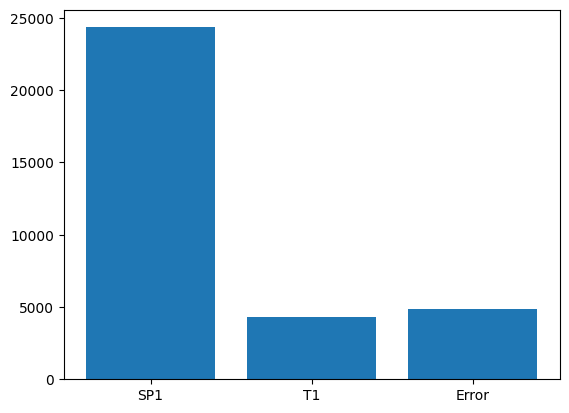

In [8]:
# Pull out the features from the data and analyze them
features = data[["SP1", "T1"]].copy()
features["Error"] = features["SP1"] - features["T1"]

_ = utils.analyze_features(features, data["Q1"].values)

In [ ]:
# Based on feature analysis, we'll use setpoint (SP1) and error

# Prepare the data for training the LSTM model
X = features[["SP1", "Error"]].values
y = data[["Q1"]].values
x_scaler, y_scaler, Xtrain, ytrain = utils.prepare_data(X, y)

# Create the model and train it (training takes several minutes)
window = Xtrain.shape[1] # window size
n_features = Xtrain.shape[2] # number of features
input_shape = (window, n_features)
model = LSTM(x_scaler, y_scaler, input_shape)

result = model.train(Xtrain, ytrain)
utils.plot_loss(result)

In [ ]:
# Save the trained model
model.save("data/lstm_control.h5")

# LSTM Validation

In [7]:
# Set this to True to generate new testing data and replace previously generated data
generate_data = False

# Create a PID controller to generate testing data
pid = PID(0, 10, 60, 0)
pid.set_bounds(0, 100)

# Generate data for testing
if generate_data or not "lstm_testing_data.csv" in os.listdir("data"):
    new_test_data = True
    data = utils.generate_tclab_data(pid, minutes=30)
    data.to_csv("data/lstm_testing_data.csv", index=False)
else:
    new_test_data = False
    data = pd.read_csv("data/lstm_testing_data.csv")

data.head()

,Time,Q1,T1,SP1
0,0.00,0.000000,20.9495,20.9495
1,1.02,0.000000,20.9495,20.9495
2,2.26,3.289609,20.6272,20.9495
3,3.10,0.066609,20.9495,20.9495
4,4.25,0.066609,20.9495,20.9495


In [8]:
# This can be 0, 1, or 2 depending on how verbose you want the output from the LSTM model to be
output_level = 0

# Load the LSTM model
h5_file = "data/lstm_control.h5"
train_data = pd.read_csv("data/lstm_training_data.csv")
train_data["Error"] = train_data["SP1"] - train_data["T1"]

X = train_data[["SP1", "Error"]].values
y = train_data[["Q1"]].values
x_scaler, y_scaler, Xtrain, ytrain = utils.prepare_data(X, y)

window = Xtrain.shape[1] # window size
n_features = Xtrain.shape[2] # number of features
input_shape = (window, n_features)
lstm = utils.load_lstm_from_h5(h5_file, x_scaler, y_scaler, input_shape)
lstm.set_output_level(output_level)

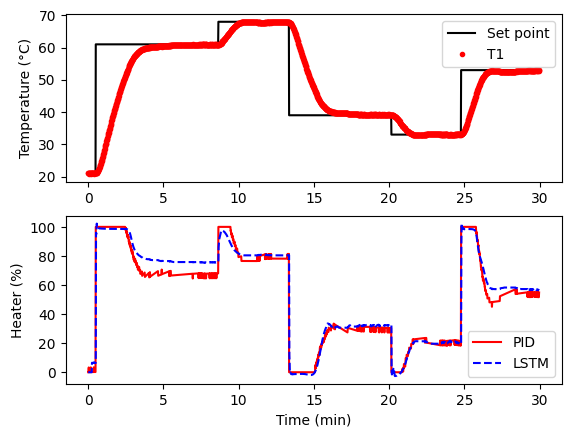

In [9]:
# Initial test of the LSTM on generated data
Q1 = data["Q1"].values
T1 = data["T1"].values
SP1 = data["SP1"].values
Q1_pred = np.zeros_like(Q1)
tm = data["Time"].values

for i in range(window, len(tm)):
    SP1_input = SP1[i - window:i]
    T1_input = T1[i - window:i]
    Q1_pred[i] = lstm(SP1_input, T1_input)

utils.plot_lstm_test(data, Q1_pred)

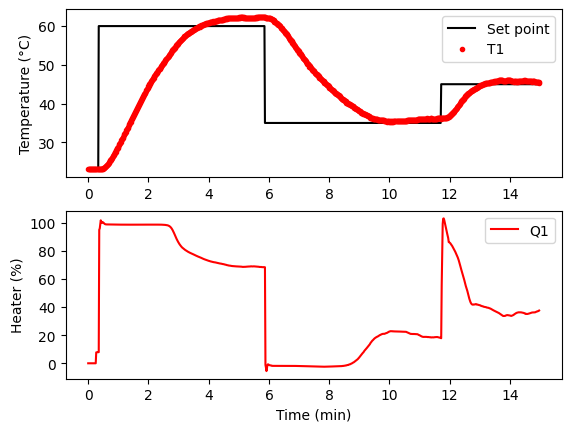

In [5]:
# Full test of the LSTM as the primary controller
TCLab = tclab.TCLab

# Uncomment this line to use the simulated tclab
# TCLab = tclab.setup(connected = False, speedup = 30)

if new_test_data:
    with TCLab() as lab:
        start_T = lab.T1

        # Set the T1 set point values
        n = 15 * 60
        T_setpoint = np.zeros(n) + start_T
        T_setpoint[20:] = 60
        T_setpoint[350:] = 35
        T_setpoint[700:] = 45

        # Control the temperature using the provided PID controller
        Q = np.zeros(n)
        T = np.zeros(n)
        tm = np.zeros(n)

        for i, t in enumerate(tclab.clock(n - 1)):
            tm[i] = t

            if i > window:
                SP1_input = T_setpoint[i - window:i]
                T1_input = T[i - window:i]
                Q[i] = lstm(SP1_input, T1_input)
            
            T[i] = lab.T1
            lab.Q1(Q[i])

    # Trim the arrays to just the values got filled in
    tm = tm[:i]
    Q = Q[:i]
    T = T[:i]
    T_setpoint = T_setpoint[:i]

    # Store the data in a pandas dataframe
    data = pd.DataFrame(np.vstack((tm, Q, T, T_setpoint)).T, columns=["Time", "Q1", "T1", "SP1"])
    data.to_csv("data/lstm_test_results.csv", index=False)

else:
    data = pd.read_csv("data/lstm_test_results.csv")

# Plot the results
utils.plot_tclab_data(data)

In [ ]:
# This code makes an animated plot with the previous results
data = pd.read_csv("data/lstm_test_results.csv")

images = []

for i in range(1, data.shape[0]):
    temp_data = data[:i]
    utils.plot_tclab_data(temp_data, to_file=f"plots/gif/plot{i}.png")
    images.append(imageio.imread(f"plots/gif/plot{i}.png"))

for _ in range(10):
    images.append(imageio.imread(f"plots/gif/plot{i}.png"))

imageio.mimsave("plots/lstm_test.gif", images, fps=10)